# FACSIMILE usage examples

Here we run through an example of using the `FACSIMILE` method on an existing questionnaire measure.

We use the [State Trait Inventory of Cognitive and Somatic Anxiety (STICSA)](https://psycnet.apa.org/record/2007-18415-001), which has an established two-factor structure. We will use the trait version (STICSA-T) for these analyses.

This notebook runs through three example uses of `FACSIMILE`:
1. Identifying a reduced set of items that can be used to accurately predict sum scores.
2. Identifying a reduced set of items that can be used to accurately predict subscale scores (e.g., cognitive and somatic anxiety).
3. Identifying a reduced set of items that can be used to accurately predict factor scores derived from exploratory factor analysis.

## Imports

First, we import the necessary packages and set some plotting parameters.

In [1]:
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from facsimile.eval import FACSIMILEOptimiser
from facsimile.plotting import plot_predictions
from facsimile.utils import (
    check_directories,
    set_style,
    train_validation_test_split,
)

# Make sure we're in the root
check_directories()

# Make things look nice
set_style("style.mplstyle")

# Set matplotlib dpi
plt.rcParams["figure.dpi"] = 100

Changing directory to root directory of repository...
Added new font as Heebo Light
Added new font as Heebo
Added new font as Heebo
Added new font as Heebo Black
Matplotlib style set to: style.mplstyle with font Heebo


## Load data

We first load in our data. This is a dataset of 1622 participants who completed the STICSA-T.

Each column corresponds to an item on the STICSA-T, and each row corresponds to a participant. There is one additional column (`subjectID`) that contains a unique identifier for each participant.

In [2]:
# Load the data
data = pd.read_csv("data/example_data.csv")

data.head()

,STICSA_T__1,STICSA_T__2,STICSA_T__3,STICSA_T__4,STICSA_T__5,STICSA_T__6,STICSA_T__7,STICSA_T__8,STICSA_T__9,STICSA_T__10,...,STICSA_T__13,STICSA_T__14,STICSA_T__15,STICSA_T__16,STICSA_T__17,STICSA_T__18,STICSA_T__19,STICSA_T__20,STICSA_T__21,subjectID
0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,subject001_study1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,subject002_study1
2,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,subject003_study1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,subject004_study1
4,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,...,0.0,1.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,subject005_study1


### Calculate sum scores

The first step is to calculate the sum scores for the STICSA-T. This is done by summing the responses to each item.

In [3]:
# Sum across rows, excluding subjectID to get the sum score
sticsa_t_sumscores = data.drop("subjectID", axis=1).sum(axis=1)

# Turn this into a new dataframe with the subjectID and the sum score
sticsa_t_sumscores = pd.concat([data["subjectID"], sticsa_t_sumscores], axis=1)

# Rename the sum score column
sticsa_t_sumscores.columns = ["subjectID", "STICSA_T_sum"]

sticsa_t_sumscores.head()

,subjectID,STICSA_T_sum
0,subject001_study1,14.0
1,subject002_study1,2.0
2,subject003_study1,8.0
3,subject004_study1,0.0
4,subject005_study1,16.0


### Calculate subscale scores

We also want to calculate scores on the two subscales, as defined in the original paper. These are the cognitive and somatic anxiety subscales.

In [4]:
# Specify the items that are somatic and cognitive
somatic_items = [1, 2, 6, 7, 8, 12, 14, 15, 18, 20, 21]

# Get column names for somatic and cognitive items
somatic_columns = [f"STICSA_T__{i}" for i in somatic_items]
cognitive_columns = [
    f"STICSA_T__{i}" for i in range(1, 22) if i not in somatic_items
]

# Calculate a subscale score for each
sticsa_t_cognitive_sumscores = data[cognitive_columns].sum(axis=1)
sticsa_t_somatic_sumscores = data[somatic_columns].sum(axis=1)

# Turn this into a new dataframe with the subjectID and the sum score
sticsa_t_cognitive_sumscores = pd.concat(
    [data["subjectID"], sticsa_t_cognitive_sumscores], axis=1
)
sticsa_t_somatic_sumscores = pd.concat(
    [data["subjectID"], sticsa_t_somatic_sumscores], axis=1
)

# Rename the sum score column
sticsa_t_cognitive_sumscores.columns = ["subjectID", "STICSA_T_cognitive_sum"]
sticsa_t_somatic_sumscores.columns = ["subjectID", "STICSA_T_somatic_sum"]

# Create a new dataframe with both subscales
sticsa_t_subscales = pd.merge(
    sticsa_t_cognitive_sumscores, sticsa_t_somatic_sumscores, on="subjectID"
)

## Predicting sum scores

First, we'll use `FACSIMILE` to identify a reduced set of items that can be used to accurately predict sum scores. This could be useful if we want to reduce the length of the questionnaire while maintaining its predictive power, which is particularly useful for very long measures (perhaps not so much for the STICSA, which is already quite short but serves as a useful example).

### Split into training, testing, and validation sets

We split our data into three datasets:
1. Training set (`X_train`, `y_train`): Used to train candidate models.
2. Validation set (`X_val`, `y_val`): Used to select the best model.
3. Testing set (`X_test`, `y_test`): Used to evaluate the performance of the selected model.

We set the training set to be the largest, with 60% of the data. The other two sets are each 20% of the data.

For this, we use a utility function in `facsimile` called `train_test_val_split`. This also randomises the order of the data, which can be useful to ensure that the data is not ordered in any way that might bias the results.

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    data.drop("subjectID", axis=1),
    sticsa_t_sumscores.drop("subjectID", axis=1),
    train_size=0.6,
    test_size=0.2,
    val_size=0.2,
)

### Run the optimiser

We want to find the best model for predicting sum scores. We use the `FACSIMILE` optimiser to do this.

This will try out different values of the regularisation parameter `alpha`, finding the items that best predict the sum scores.

This example is quite simple since we have few items and we're predicting a single value (this means there's only a single `alpha` to optimise), so the optimisation procedure here is probably a little much. However, we run through it as we would on a more complex dataset.

In [6]:
# Initialise the optimiser
optimiser = FACSIMILEOptimiser(n_iter=1000, n_jobs=10, alpha_dist_scaling=8)

# Fit
optimiser.fit(X_train, y_train, X_val, y_val, target_names=["STICSA_T_sum"])

Evaluation: 100%|██████████| 1000/1000 [00:02<00:00, 350.68it/s]


We can then plot the results of the optimisation procedure.

On the `x` axis, we have the number of included items. On the `y` axis, we have the performance of the model on the validation set, using the $R^2$ metric.

We can see that increasing the number of items included in the model generally improves performance, but we can still achieve high levels of accuracy with a small number of items. For eample, we still get >0.9 $R^2$ with only 10 items.

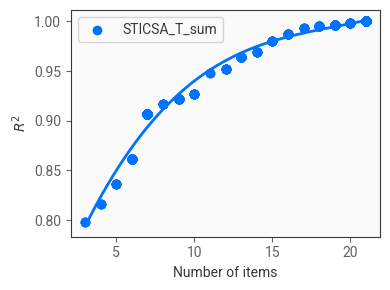

In [7]:
optimiser.plot_results(figsize=(4, 3))

### Extract classifiers

We can then extract the best performing classifier. There are a couple of ways to do this.

The first is to use the `get_best_classifier` method, which will return the classifier that performed best on the validation set. "Best" is somewhat subjective, but the optimiser uses a metric that attempts to balance accuracy against the number of items included. Specifically, the score is definedas the minimum $R^2$ value across the 3 factors, multiplied by 1 minus the number of included items divided by the total number of items:

$$
\text{score} = \min(R^2) \times \left(1 - \frac{\text{num items}}{\text{total items}}\right)
$$

The `get_best_classifier` method will return the classifier with the highest score, but returns it in a pre-fitting state. This means that it will need to be fit to the data using the `.fit()` method.

It can then be used to predict scores on a new dataset (here, the test set) using the `.predict()` method.

We can also use the included `plot_predictions()` function to plot the predicted scores against the true scores.



Best classifier:
Minimum R^2: 0.7979792696696075
Number of included items: 3.0


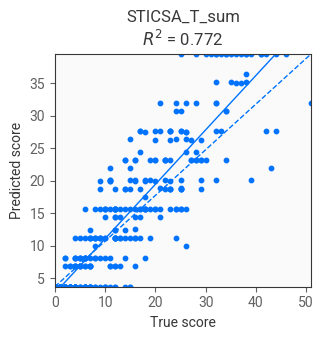

In [8]:
clf = optimiser.get_best_classifier()

# Fit and get predictions
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Plot
plot_predictions(
    y_test, y_pred, ["STICSA_T_sum"], scale=1, scatter_kws={"s": 10}
)

We can also view a heatmap of the weights on the included items.

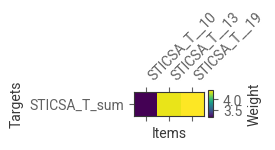

In [9]:
clf.plot_weights()

Alternatively, we might have a number of items that we consider acceptable (for example, we might have a 100-item measure that we want to cut in half, leaving 50 items.) 

In this case, we can use the `get_best_classifier_max_items` method, supplying the number of items we will accept. This will return the best-performing classifier (based on the $R^2$ score) that includes no more than the specified number of items.

Here, we'll use this method to get a classifier that includes at most 12 items.

Best classifier:
Minimum R^2: 0.9523508368452341
Number of included items: 12.0


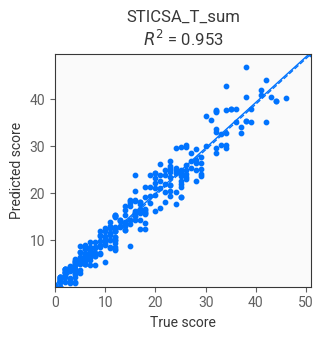

In [10]:
clf = optimiser.get_best_classifier_max_items(12, metric="min_r2")

# Fit and get predictions
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Plot
plot_predictions(
    y_test, y_pred, ["STICSA_T_sum"], scale=1, scatter_kws={"s": 10}
)

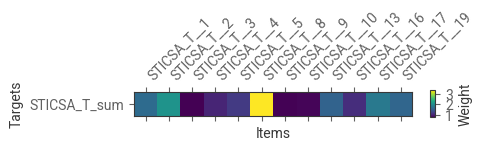

In [11]:
clf.plot_weights()

### Get the shortest scale for a given performance

We can also ask for the shortest scale that achieves a given performance according to a metric such as the $R^2$ score. This can be done using the `get_classifier_by_metric` method.

Here, we'll ask for the shortest scale that achieves an $R^2$ score of 0.95.

In [12]:
best_clf_95 = optimiser.get_classifier_by_metric(0.95)

# Fit
best_clf_95.fit(X_train, y_train)

Classifier with the lowest n_items:
min_r2: 0.9523508368452341
Number of included items: 12.0


FACSIMILE(alphas=array([2.40078799]))

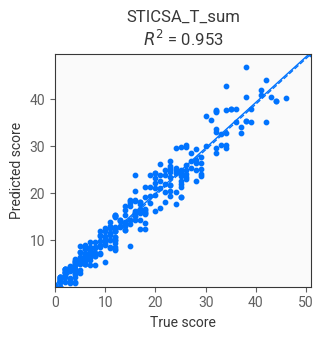

In [13]:
# Get predictions
y_pred_95 = best_clf_95.predict(X_test)

# Plot
plot_predictions(y_test, y_pred_95, ["STICSA_T_sum"], scale=1, scatter_kws={"s": 10})

## Predicting subscale scores

We can also use `FACSIMILE` to identify a reduced set of items that can be used to accurately predict subscale scores, rather than the sum score for the entire measure.

The procedure is virtually the same, but rather than supplying the sum score as the target variable, we supply the subscale scores. This can be any number of subscales - here, we use the cognitive and somatic anxiety subscales of the STICSA.

### Split into training, testing, and validation sets

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    data.drop("subjectID", axis=1),
    sticsa_t_subscales.drop("subjectID", axis=1),
    train_size=0.6,
    test_size=0.2,
    val_size=0.2,
)

### Run the optimiser

The optimisation procedure is essentially the same as before, but we're now predicting two values rather than one.

In [15]:
# Initialise the optimiser
optimiser = FACSIMILEOptimiser(n_iter=1000, n_jobs=10, alpha_dist_scaling=6)

# Fit
optimiser.fit(
    X_train,
    y_train,
    X_val,
    y_val,
    target_names=["Cognitive", "Somatic"],
)

Evaluation: 100%|██████████| 1000/1000 [00:01<00:00, 744.80it/s]


Again, we can plot the results of the optimisation procedure.

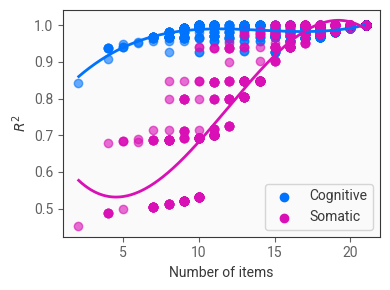

In [16]:
optimiser.plot_results(figsize=(4, 3))

### Extract classifiers

We can use the same methods as before the extract the best-performing classifiers.



Best classifier:
Minimum R^2: 0.6778775854585568
Number of included items: 4.0


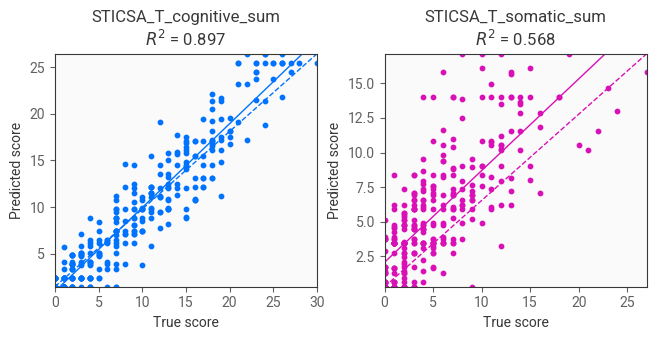

In [17]:
clf = optimiser.get_best_classifier()

# Fit and get predictions
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Plot
plot_predictions(
    y_test,
    y_pred,
    ["STICSA_T_cognitive_sum", "STICSA_T_somatic_sum"],
    scale=1,
    scatter_kws={"s": 10},
)

Best classifier:
Minimum R^2: 0.9500757134262975
Number of included items: 12.0


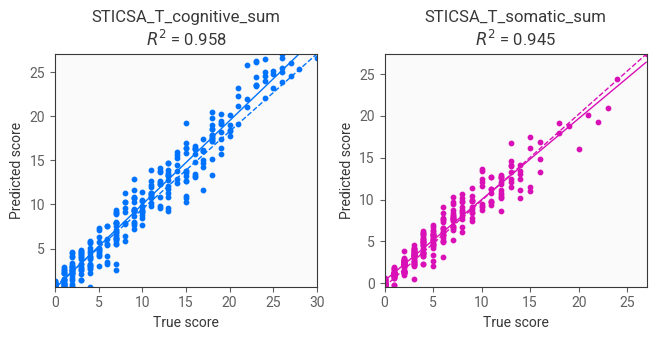

In [18]:
clf = optimiser.get_best_classifier_max_items(12, metric="min_r2")

# Fit and get predictions
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Plot
plot_predictions(
    y_test,
    y_pred,
    ["STICSA_T_cognitive_sum", "STICSA_T_somatic_sum"],
    scale=1,
    scatter_kws={"s": 10},
)

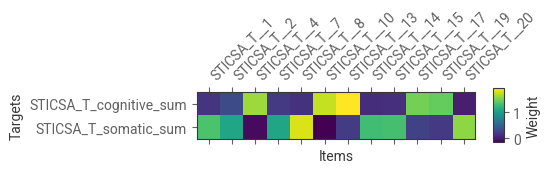

In [19]:
clf.plot_weights()

## Predicting factor scores

Finally, we can use `FACSIMILE` to identify a reduced set of items that can be used to accurately predict factor scores derived from exploratory factor analysis.

This works in the same way as the previous example with subscores, but we're now predicting factor scores rather than subscale scores.

> ⚠️ **Note**: This requires the [`factor_analyzer`](https://factor-analyzer.readthedocs.io/en/latest/) package to be installed. This is not a requirement of `facsimile` itself, but is required for this specific example.
>
> You can install this package using `pip install factor_analyzer`.

First, we'll run an exploratory factor analysis on our data (we'll ignore the details of this as it's just done for demonstration purposes).

Importantly, we can extract the factor scores for each participant and assign them to a variable called `scores`.

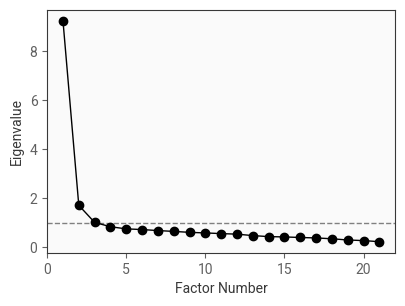

In [20]:
# Import the FactorAnalyzer class
from factor_analyzer import FactorAnalyzer

# Run factor analysis on data
fa = FactorAnalyzer(
    n_factors=2,
    rotation="oblimin",  # factors are expected to be somewhat correlated
    method="ml",
    is_corr_matrix=False,
)

fa.fit(data.drop("subjectID", axis=1))

ev, _ = fa.get_eigenvalues()

# Save eigenvalues to a DataFrame
ev_df = pd.DataFrame(ev, columns=["Eigenvalues"])

# Plot the eigenvalues
f, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.axhline(1, color="gray", linestyle="--")
ax.plot(ev_df.index + 1, ev_df["Eigenvalues"], "o-", color="black")

# Set labels
ax.set_xlabel("Factor Number")
ax.set_ylabel("Eigenvalue")

# Get loadings
loadings = fa.loadings_

# Get scores
scores = fa.transform(data.drop("subjectID", axis=1))

scores = pd.DataFrame(scores, columns=["Factor 1", "Factor 2"])
scores["subjectID"] = data["subjectID"]

We can see from the scree plot that 2 factors looks like a good choice for this dataset.

### Plot the item loadings

We can check the items loadings too - these should line up with the subscales.

We plot the `x` tick labels in colours that correspond to the subscales, to make it easier to see which items should correspond to which factors.

In general, it looks like our factor analysis reproduces the factor structure of the STICSA-T.

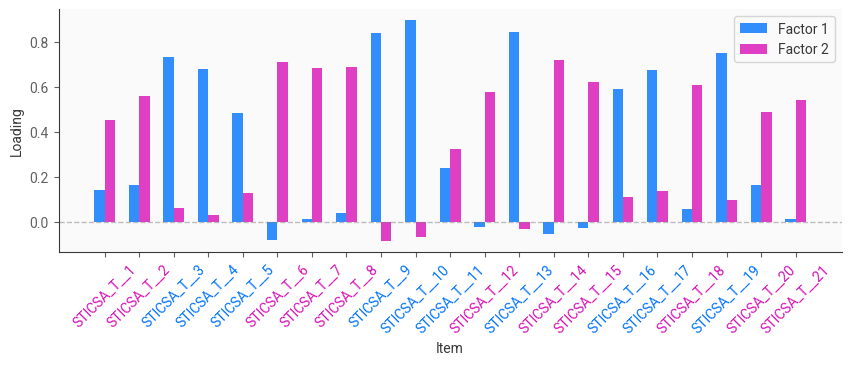

In [21]:
# Plot
f, ax = plt.subplots(1, 1, figsize=(9, 3))

# Line at y == 0
ax.axhline(0, color="gray", linestyle="--", alpha=0.5)

ax.bar(
    np.arange(1, loadings.shape[0] + 1) - 0.15,
    loadings[:, 0],
    alpha=0.8,
    width=0.3,
    label="Factor 1",
)
ax.bar(
    np.arange(1, loadings.shape[0] + 1) + 0.15,
    loadings[:, 1],
    alpha=0.8,
    width=0.3,
    label="Factor 2",
)

# Set xlabels
ax.set_xticks(np.arange(1, loadings.shape[0] + 1))

# Highlight the somatic item labels
somatic_items = [1, 2, 6, 7, 8, 12, 14, 15, 18, 20, 21]
somatic_item_labels = [f"STICSA_T__{i}" for i in somatic_items]
somatic_item_indices = [data.columns.get_loc(i) for i in somatic_item_labels]

ax.set_xticklabels(data.drop("subjectID", axis=1).columns, rotation=45)

# Get colour cycle
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Highlight the somatic items
for i in range(21):
    if i in somatic_item_indices:
        ax.get_xticklabels()[i].set_color(colours[1])
    else:
        ax.get_xticklabels()[i].set_color(colours[0])

# Despine
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# X/Y labels
ax.set_xlabel("Item")
ax.set_ylabel("Loading")

# Legend
ax.legend()

### Split into training, testing, and validation sets

We can now divide our data up again, this time using the factor scores as the target variable.

In [22]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    data.drop("subjectID", axis=1),
    scores.drop("subjectID", axis=1),
    train_size=0.6,
    test_size=0.2,
    val_size=0.2,
)

### Run the optimiser

The optimisation procedure is the same as before.

In [23]:
# Initialise the optimiser
optimiser = FACSIMILEOptimiser(n_iter=1000, n_jobs=10, alpha_dist_scaling=1)

# Fit
optimiser.fit(
    X_train,
    y_train,
    X_val,
    y_val,
    target_names=["Factor_1", "Factor_2"],
)

Evaluation: 100%|██████████| 1000/1000 [00:01<00:00, 818.84it/s]


And the results look a lot like when we used the subscale scores.

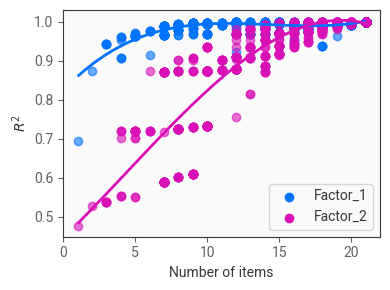

In [24]:
optimiser.plot_results(figsize=(4, 3))

### Extract classifiers

We can use the same methods as before the extract the best-performing classifiers.



Best classifier:
Minimum R^2: 0.8742978026880882
Number of included items: 6.0


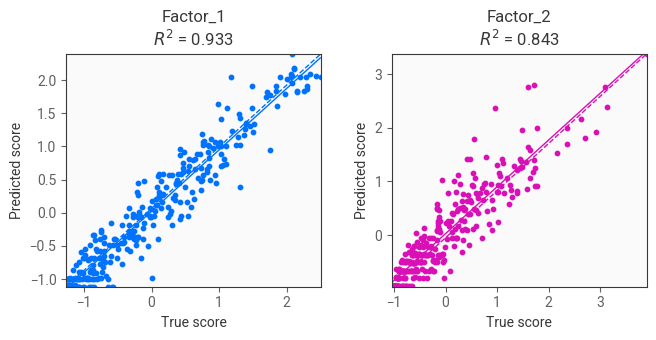

In [25]:
clf = optimiser.get_best_classifier()

# Fit and get predictions
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Plot
plot_predictions(
    y_test, y_pred, ["Factor_1", "Factor_2"], scale=1, scatter_kws={"s": 10}
)

Best classifier:
Minimum R^2: 0.9693035358903709
Number of included items: 12.0


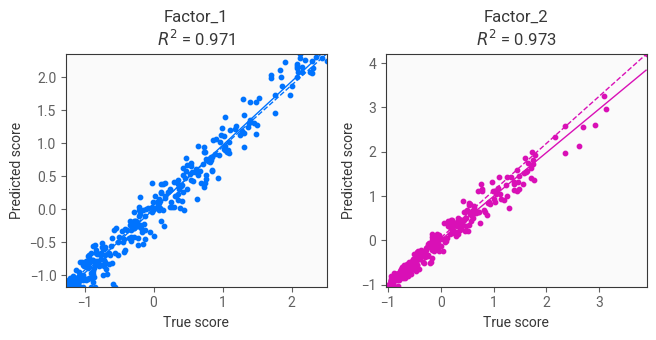

In [26]:
clf = optimiser.get_best_classifier_max_items(12, metric="min_r2")

# Fit and get predictions
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Plot
plot_predictions(
    y_test, y_pred, ["Factor_1", "Factor_2"], scale=1, scatter_kws={"s": 10}
)